In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


pd.options.display.max_columns = None

In [85]:
trips = pd.read_csv("data/201812-fordgobike-tripdata.csv")
weather = pd.read_csv('data/weather.csv')

In [86]:



def feature_addition(df):
    '''
    INPUT dataframe
    OUTPUT dataframe with extra features
    '''
    #create a new column that shows the day of week for each trip
    #need to transform panda series to datetime
    #before we can use .dt.dayofweek
    #monday = 0 and sunday = 6

    df.start_time = pd.to_datetime(df.start_time)

    df['day_of_week'] = df.start_time.dt.dayofweek

    df['date'] = df.start_time.dt.date
    df['hour'] = df.start_time.dt.hour

    #any trip with less than 90 seconds and where
    #start station IS the end station,
    #we make the assumption that its malfunctioned
    df['malfunction'] = (df.duration_sec < 90) & (df.start_station_name == df.end_station_name)
    df['age'] = 2019 - df.member_birth_year

    return df

def num_malfunctions(df):
    '''
    INPUT: Dataframe with a "malfunction" column
    Sum the number of malfunctions up
    OUTPUT: Tuple with 
            first element as number of malfunctions and
            second element as number of non-malfunctions
    '''

    num_malfunctions = df.malfunction.sum()
    num_working = len(df.malfunction) - num_malfunctions

    return (num_malfunctions, num_working)

def frequent_malfunction(df):
    return df.bike_id[df.malfunction == True].value_counts()

def same_station(df):
    return df.bike_id[df.start_station_name == df.end_station_name].value_counts()

def model_city(df, city = 1):
    '''
    Breaks the dataset into 3 cities
    SF = 1
    OAK = 2
    SJ = 3

    INPUT: Dataframe
           Number for city to be modeled
    OUTPUT: returns a portion of the original dataframe
    ''' 
    if city == 1:
        return df[(df.end_station_latitude > 37.697799) & (df.end_station_longitude <-122.330676)]
    elif city == 2:
        return df[(df.end_station_latitude > 37.697799) & (df.end_station_longitude >-122.330676)]
    elif city == 3:
        return df[df.end_station_latitude < 37.697799]


def get_dummies(df):
    
    #start station dummies
    start_dummies = pd.get_dummies(df.start_station_name)
    #end station dummies
    end_dummies = pd.get_dummies(df.end_station_name)
    df = pd.concat([df,start_dummies], axis=1)
    df = pd.concat([df,end_dummies], axis=1)
    
    return df

def merge_dfs(df1, df2, column = 'date'):
    '''
    INPUT df1 is the trips dataframe
          df2 is the weather dataframe
    OUTPUT 1 combined dataframe
    '''
    df2['tavg'] = (df2.tmax + df2.tmin)/2
    df2[column] = pd.to_datetime(df2[column])
    df2[column] = df2[column].dt.date
    combined_df = pd.merge(df1,df2, on='date', how='left')
    return combined_df


In [4]:

df = feature_addition(trips)


sf = model_city(df,1).reset_index()
sf.drop(['index'], axis = 1, inplace = True)
weather.columns = map(str.lower, weather.columns)

In [5]:
sf.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,day_of_week,date,hour,malfunction,age
0,30550,2018-12-31 19:26:20.775,2019-01-01 03:55:30.7930,13.0,Commercial St at Montgomery St,37.794231,-122.402923,19.0,Post St at Kearny St,37.788975,-122.403452,5422,Subscriber,1986.0,Male,Yes,0,2018-12-31,19,False,33.0
1,2150,2018-12-31 23:59:12.097,2019-01-01 00:35:02.1530,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,-122.419622,4820,Customer,NaN,NaN,No,0,2018-12-31,23,False,NaN


In [6]:
gender = pd.get_dummies(df.member_gender)

In [7]:
sf = sf.join(gender, how="left")

In [8]:
#there are outliers in duration
#this is only 1 similar trip(point A and B are equal)
np.array(sf.duration_sec[(sf.start_station_id == 13) & (sf.end_station_id == 19)]).reshape(1,-1)

array([[30550,   439,  1501,   360,   254,   389,   317,   190,   421,
         9068,   249,   465,   367,   234]])

In [9]:
#names of each start station and the number of trips 
lst_start_station_name = sf.start_station_name.value_counts()
#ids of each start station and the number of trips 
lst_start_station_id = sf.start_station_id.value_counts()

num_unique_stations = lst_start_station_id.unique().size



In [10]:
unique_start_sations = sf.start_station_id.unique()
unique_end_stations = sf.end_station_id.unique()
len(unique_end_stations), len(unique_start_sations)

(148, 152)

(array([12.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  190.,  3226.,  6262.,  9298., 12334., 15370., 18406., 21442.,
        24478., 27514., 30550.]),
 <a list of 10 Patch objects>)

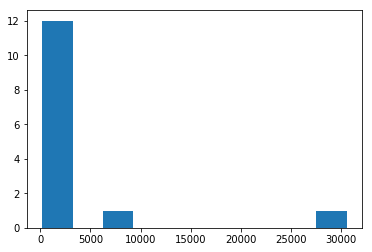

In [11]:

plt.hist(sf.duration_sec[(sf.start_station_id == 13) & (sf.end_station_id == 19)])

In [12]:
# sf['avg_duration'] = 1
# sf

### calculating average for similar trips

In [99]:
#avg time for similar trips
#for example
#trips start at station 13
#ending with station 19
# sf['avg_duration'][(sf.start_station_id == 13) & (sf.end_station_id == 19)] = sf[(sf.start_station_id == 13) & (sf.end_station_id == 19)]['duration_sec'].mean()
avg_time_arr = np.zeros([1,3])
for s in unique_start_sations:
    for e in unique_end_stations:
        avg_time = sf[(sf.start_station_id == s) & (sf.end_station_id == e)]['duration_sec'].mean()
        b = np.array([s,e,avg_time])
        avg_time_arr = np.vstack((avg_time_arr, b))

In [100]:
np.set_printoptions(suppress=True)

In [107]:
avg_time_df = pd.DataFrame(avg_time_arr[1:])

In [108]:
avg_time_df

,0,1,2
0,13.0,19.0,3200.285714
1,13.0,368.0,1130.000000
2,13.0,44.0,699.333333
3,13.0,16.0,403.687500
4,13.0,21.0,369.645833
5,13.0,8.0,2238.428571
6,13.0,9.0,249.000000
7,13.0,23.0,576.750000
8,13.0,95.0,1126.500000
9,13.0,324.0,637.000000


In [14]:
#function takes too long
#need to parallelize it

# import time
# start = time.time()
# for s in unique_start_sations[:50]:
#     for e in unique_end_stations[:50]:
#         sf['avg_duration'][(sf.start_station_id == s) & (sf.end_station_id == e)] = sf[(sf.start_station_id == s) & (sf.end_station_id == e)]['duration_sec'].mean()
        
# end = time.time()
# print(end - start) 

In [15]:
# master = merge_dfs(sf, weather)

In [16]:
#check to see if there are any columns with NaN values
#if there are any, append it to a list for now
# columns_w_NaN = []
# for c in list(master.columns.values):
#     if master[c].isna().any():
#         columns_w_NaN.append(c)

In [17]:
# master.member_birth_year.isna().sum()

In [18]:
# master.head(2)

In [19]:
#exploring the distribution of end stations given a start station


In [20]:
c_df = merge_dfs(sf, weather)

## Remove NaN values

In [21]:
c_df = c_df[c_df.member_birth_year.isna() == False]

In [22]:
c_df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,day_of_week,date,hour,malfunction,age,Female,Male,Other,station,name,latitude,longitude,elevation,prcp,prcp_attributes,snow,snow_attributes,snwd,snwd_attributes,tavg,tavg_attributes,tmax,tmax_attributes,tmin,tmin_attributes
0,30550,2018-12-31 19:26:20.775,2019-01-01 03:55:30.7930,13.0,Commercial St at Montgomery St,37.794231,-122.402923,19.0,Post St at Kearny St,37.788975,-122.403452,5422,Subscriber,1986.0,Male,Yes,0,2018-12-31,19,False,33.0,0,0,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.0,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W"
2,2149,2018-12-31 23:59:11.882,2019-01-01 00:35:01.6850,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,-122.419622,5549,Subscriber,1982.0,Male,Yes,0,2018-12-31,23,False,37.0,0,1,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.0,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W"


## Identifying the 3 nearest stations
### this will be my new label

In [23]:
#identifying the 3 closest stations using knn
#to store:
#create a dictionary with 
#key = station id
#values = list of the 3 closest stations

In [24]:
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=3)


In [25]:

def euclidean_distance(x, y):
    return np.sqrt(((x-y)**2).sum(axis=1))

In [26]:
#getting the coordinates from the dataset
coordinates = np.array(c_df[['end_station_longitude', 'end_station_latitude']])

In [27]:
#return only the unique coordinates
unique_coords = np.unique(coordinates, axis = 0)
unique_coords

array([[-122.45370448,   37.77191688],
       [-122.44729131,   37.77904666],
       [-122.44654566,   37.77483629],
       [-122.4442926 ,   37.77331088],
       [-122.4418376 ,   37.7774157 ],
       [-122.43944585,   37.7824046 ],
       [-122.4390777 ,   37.7730627 ],
       [-122.4377775 ,   37.775946  ],
       [-122.4369431 ,   37.7591769 ],
       [-122.4368608 ,   37.7789994 ],
       [-122.4356498 ,   37.772406  ],
       [-122.43455887,   37.78381271],
       [-122.4339496 ,   37.750506  ],
       [-122.4338119 ,   37.7692005 ],
       [-122.4337079 ,   37.7717933 ],
       [-122.4326417 ,   37.7610471 ],
       [-122.4319464 ,   37.78045006],
       [-122.4318042 ,   37.764285  ],
       [-122.43115783,   37.78352084],
       [-122.4310597 ,   37.7662185 ],
       [-122.4306746 ,   37.7632417 ],
       [-122.4295585 ,   37.7770527 ],
       [-122.4291557 ,   37.7700831 ],
       [-122.4274114 ,   37.7509004 ],
       [-122.4273169 ,   37.77341397],
       [-122.4268256 ,   

In [28]:
#create a dictionary with
#station id as key
#coordinates for the station id as values
id_coord = {}
for u in unique_coords:
    k = c_df.end_station_id[(c_df.end_station_longitude == u[0]) &(c_df.end_station_latitude == u[1])].iloc[0]
    id_coord[k] = u

id_coord

{377.0: array([-122.45370448,   37.77191688]),
 380.0: array([-122.44729131,   37.77904666]),
 375.0: array([-122.44654566,   37.77483629]),
 70.0: array([-122.4442926 ,   37.77331088]),
 52.0: array([-122.4418376,   37.7774157]),
 29.0: array([-122.43944585,   37.7824046 ]),
 71.0: array([-122.4390777,   37.7730627]),
 53.0: array([-122.4377775,   37.775946 ]),
 118.0: array([-122.4369431,   37.7591769]),
 39.0: array([-122.4368608,   37.7789994]),
 72.0: array([-122.4356498,   37.772406 ]),
 31.0: array([-122.43455887,   37.78381271]),
 137.0: array([-122.4339496,   37.750506 ]),
 84.0: array([-122.4338119,   37.7692005]),
 73.0: array([-122.4337079,   37.7717933]),
 119.0: array([-122.4326417,   37.7610471]),
 365.0: array([-122.4319464 ,   37.78045006]),
 105.0: array([-122.4318042,   37.764285 ]),
 285.0: array([-122.43115783,   37.78352084]),
 95.0: array([-122.4310597,   37.7662185]),
 106.0: array([-122.4306746,   37.7632417]),
 55.0: array([-122.4295585,   37.7770527]),
 85.0:

In [29]:
t = 59
#the coordinate for the station in the t-th position
trgt_station = unique_coords[t]

In [30]:
#n closest neighbors for the station in the t-th position
n=3
neighbors = unique_coords[np.argsort(euclidean_distance(trgt_station, unique_coords))][0:n]

In [31]:
#target station id #
# sf.end_station_id[(sf.end_station_longitude == trgt_station[0]) &(sf.end_station_latitude == trgt_station[1])].iloc[0]


In [32]:
neighbors

array([[-122.415674 ,   37.769757 ],
       [-122.4154425,   37.7670373],
       [-122.4160402,   37.7735069]])

In [33]:
#getting the knn station id #s
for i in range(n):
    knn_id = c_df.end_station_id[(c_df.end_station_longitude == neighbors[i][0]) &(c_df.end_station_latitude == neighbors[i][1])].iloc[0]
    print(knn_id)

87.0
99.0
77.0


In [34]:
knn_dict = {}
for tu in unique_coords:
    neighbors = unique_coords[np.argsort(euclidean_distance(tu, unique_coords))][1:4]
    k = c_df.end_station_id[(c_df.end_station_longitude == tu[0]) &(c_df.end_station_latitude == tu[1])].iloc[0]
    v = [k]
    for i in range(n):
        knn_id = c_df.end_station_id[(c_df.end_station_longitude == neighbors[i][0]) &(c_df.end_station_latitude == neighbors[i][1])].iloc[0]
        v.append(knn_id)
    knn_dict[k] = v
knn_dict

{377.0: [377.0, 375.0, 70.0, 380.0],
 380.0: [380.0, 375.0, 52.0, 70.0],
 375.0: [375.0, 70.0, 380.0, 52.0],
 70.0: [70.0, 375.0, 52.0, 71.0],
 52.0: [52.0, 53.0, 70.0, 71.0],
 29.0: [29.0, 39.0, 31.0, 52.0],
 71.0: [71.0, 53.0, 72.0, 52.0],
 53.0: [53.0, 71.0, 39.0, 72.0],
 118.0: [118.0, 119.0, 105.0, 106.0],
 39.0: [39.0, 53.0, 29.0, 365.0],
 72.0: [72.0, 73.0, 71.0, 84.0],
 31.0: [31.0, 285.0, 365.0, 29.0],
 137.0: [137.0, 138.0, 132.0, 118.0],
 84.0: [84.0, 73.0, 72.0, 95.0],
 73.0: [73.0, 72.0, 84.0, 85.0],
 119.0: [119.0, 106.0, 105.0, 118.0],
 365.0: [365.0, 285.0, 55.0, 31.0],
 105.0: [105.0, 106.0, 95.0, 119.0],
 285.0: [285.0, 365.0, 31.0, 55.0],
 95.0: [95.0, 105.0, 106.0, 84.0],
 106.0: [106.0, 105.0, 119.0, 95.0],
 55.0: [55.0, 74.0, 365.0, 56.0],
 85.0: [85.0, 86.0, 56.0, 95.0],
 138.0: [138.0, 132.0, 140.0, 137.0],
 56.0: [56.0, 74.0, 85.0, 86.0],
 86.0: [86.0, 85.0, 96.0, 56.0],
 145.0: [145.0, 146.0, 140.0, 142.0],
 132.0: [132.0, 138.0, 140.0, 134.0],
 96.0: [96.0, 8

## Visualize stations

The origin station is 59.
The 3 closest neighbors are: 59, 58, 75


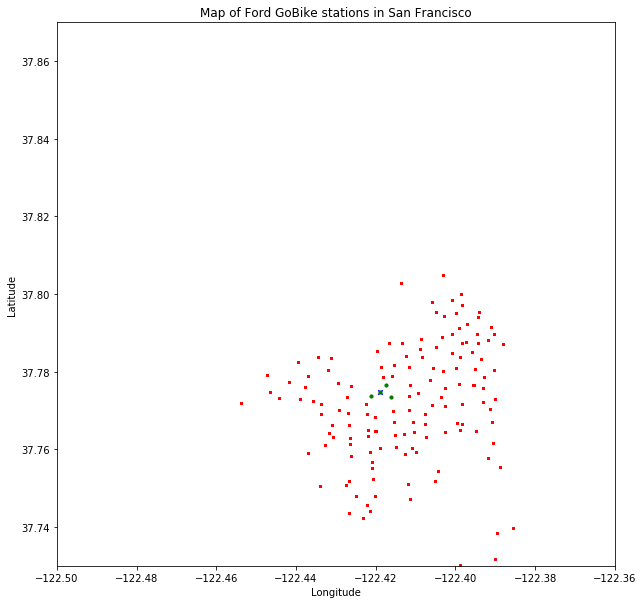

In [35]:
print("The origin station is {}.".format(t))
print("The 3 closest neighbors are: {}, {}, {}".format(int(knn_dict.get(t)[0]),int(knn_dict.get(t)[1]),int(knn_dict.get(t)[2])))
plt.figure(figsize = (10,10))
ll,rr = -122.50, -122.36
bb = 37.73
plt.xlim(ll,rr)
plt.ylim(bb, bb+(rr-ll))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map of Ford GoBike stations in San Francisco")
plt.scatter(c_df.end_station_longitude, c_df.end_station_latitude, s=1, c=('r'))
plt.scatter(id_coord.get(t)[0], id_coord.get(t)[1], s=20, marker='x', c=('b'))

for st in knn_dict.get(t):
    plt.scatter(id_coord.get(st)[0],id_coord.get(st)[1], s= 10, c='g')
plt.show()



In [36]:
for st in knn_dict.get(t):
    print(id_coord.get(st))

[-122.418954   37.774814]
[-122.417385   37.776619]
[-122.42123902   37.77379321]
[-122.4160402   37.7735069]


## Adding knn to df

In [37]:
c_df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,day_of_week,date,hour,malfunction,age,Female,Male,Other,station,name,latitude,longitude,elevation,prcp,prcp_attributes,snow,snow_attributes,snwd,snwd_attributes,tavg,tavg_attributes,tmax,tmax_attributes,tmin,tmin_attributes
0,30550,2018-12-31 19:26:20.775,2019-01-01 03:55:30.7930,13.0,Commercial St at Montgomery St,37.794231,-122.402923,19.0,Post St at Kearny St,37.788975,-122.403452,5422,Subscriber,1986.0,Male,Yes,0,2018-12-31,19,False,33.0,0,0,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.0,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W"
2,2149,2018-12-31 23:59:11.882,2019-01-01 00:35:01.6850,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,-122.419622,5549,Subscriber,1982.0,Male,Yes,0,2018-12-31,23,False,37.0,0,1,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.0,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W"


In [38]:
knn_dict

{377.0: [377.0, 375.0, 70.0, 380.0],
 380.0: [380.0, 375.0, 52.0, 70.0],
 375.0: [375.0, 70.0, 380.0, 52.0],
 70.0: [70.0, 375.0, 52.0, 71.0],
 52.0: [52.0, 53.0, 70.0, 71.0],
 29.0: [29.0, 39.0, 31.0, 52.0],
 71.0: [71.0, 53.0, 72.0, 52.0],
 53.0: [53.0, 71.0, 39.0, 72.0],
 118.0: [118.0, 119.0, 105.0, 106.0],
 39.0: [39.0, 53.0, 29.0, 365.0],
 72.0: [72.0, 73.0, 71.0, 84.0],
 31.0: [31.0, 285.0, 365.0, 29.0],
 137.0: [137.0, 138.0, 132.0, 118.0],
 84.0: [84.0, 73.0, 72.0, 95.0],
 73.0: [73.0, 72.0, 84.0, 85.0],
 119.0: [119.0, 106.0, 105.0, 118.0],
 365.0: [365.0, 285.0, 55.0, 31.0],
 105.0: [105.0, 106.0, 95.0, 119.0],
 285.0: [285.0, 365.0, 31.0, 55.0],
 95.0: [95.0, 105.0, 106.0, 84.0],
 106.0: [106.0, 105.0, 119.0, 95.0],
 55.0: [55.0, 74.0, 365.0, 56.0],
 85.0: [85.0, 86.0, 56.0, 95.0],
 138.0: [138.0, 132.0, 140.0, 137.0],
 56.0: [56.0, 74.0, 85.0, 86.0],
 86.0: [86.0, 85.0, 96.0, 56.0],
 145.0: [145.0, 146.0, 140.0, 142.0],
 132.0: [132.0, 138.0, 140.0, 134.0],
 96.0: [96.0, 8

In [39]:
dict_df = pd.DataFrame(pd.Series(knn_dict).reset_index()).set_axis(['Key','Value'],1,inplace=False)
                                                                       

In [40]:
dict_df.columns = ['end_station_id', 'neighbor_stations']

In [41]:
labeled_df = pd.merge(c_df, dict_df, on ='end_station_id', how='left')

In [42]:
labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92583 entries, 0 to 92582
Data columns (total 42 columns):
duration_sec               92583 non-null int64
start_time                 92583 non-null datetime64[ns]
end_time                   92583 non-null object
start_station_id           92583 non-null float64
start_station_name         92583 non-null object
start_station_latitude     92583 non-null float64
start_station_longitude    92583 non-null float64
end_station_id             92583 non-null float64
end_station_name           92583 non-null object
end_station_latitude       92583 non-null float64
end_station_longitude      92583 non-null float64
bike_id                    92583 non-null int64
user_type                  92583 non-null object
member_birth_year          92583 non-null float64
member_gender              92583 non-null object
bike_share_for_all_trip    92583 non-null object
day_of_week                92583 non-null int64
date                       92583 non-null obje

In [43]:
labeled_df.user_type = labeled_df.user_type.replace({'Subscriber': 1, "Customer" : 0})

In [44]:
labeled_df

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,day_of_week,date,hour,malfunction,age,Female,Male,Other,station,name,latitude,longitude,elevation,prcp,prcp_attributes,snow,snow_attributes,snwd,snwd_attributes,tavg,tavg_attributes,tmax,tmax_attributes,tmin,tmin_attributes,neighbor_stations
0,30550,2018-12-31 19:26:20.775,2019-01-01 03:55:30.7930,13.0,Commercial St at Montgomery St,37.794231,-122.402923,19.0,Post St at Kearny St,37.788975,-122.403452,5422,1,1986.0,Male,Yes,0,2018-12-31,19,False,33.0,0,0,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.00,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W","[19.0, 21.0, 3.0, 284.0]"
1,2149,2018-12-31 23:59:11.882,2019-01-01 00:35:01.6850,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,368.0,Myrtle St at Polk St,37.785434,-122.419622,5549,1,1982.0,Male,Yes,0,2018-12-31,23,False,37.0,0,1,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.00,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W","[368.0, 369.0, 41.0, 33.0]"
2,2502,2018-12-31 23:46:24.943,2019-01-01 00:28:07.3560,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,44.0,Civic Center/UN Plaza BART Station (Market St ...,37.781074,-122.411738,4706,0,1973.0,Male,No,0,2018-12-31,23,False,46.0,0,1,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.00,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W","[44.0, 34.0, 33.0, 5.0]"
3,8202,2018-12-31 22:11:22.506,2019-01-01 00:28:05.1730,324.0,Union Square (Powell St at Post St),37.788300,-122.408531,16.0,Steuart St at Market St,37.794130,-122.394430,5518,0,1995.0,Male,No,0,2018-12-31,22,False,24.0,0,0,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.00,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W","[16.0, 15.0, 17.0, 23.0]"
4,2170,2018-12-31 23:47:19.210,2019-01-01 00:23:30.1300,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,4800,0,1999.0,Female,No,0,2018-12-31,23,False,20.0,0,1,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.00,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W","[21.0, 20.0, 19.0, 363.0]"
5,3645,2018-12-31 23:22:41.286,2019-01-01 00:23:27.2680,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,8.0,The Embarcadero at Vallejo St,37.799953,-122.398525,4747,0,1999.0,Male,No,0,2018-12-31,23,False,20.0,0,1,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.00,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W","[8.0, 11.0, 9.0, 14.0]"
6,2182,2018-12-31 23:47:02.185,2019-01-01 00:23:24.4950,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,5426,0,1999.0,Female,No,0,2018-12-31,23,False,20.0,0,1,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.00,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W","[21.0, 20.0, 19.0, 363.0]"
7,868,2018-12-31 23:46:34.411,2019-01-01 00:01:02.7040,350.0,8th St at Brannan St,37.771431,-122.405787,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,4615,1,1984.0,Male,No,0,2018-12-31,23,False,35.0,0,1,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.00,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W","[23.0, 24.0, 27.0, 22.0]"
8,814,2018-12-31 23:47:20.294,2019-01-01 00:00:54.9200,350.0,8th St at Brannan St,37.771431,-122.405787,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,4811,1,1988.0,Female,No,0,2018-12-31,23,False,31.0,1,0,0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,0.00,",,W,2400",0.0,",,W",0.0,",,W",51.5,NaN,56,",,W",47,",,W","[23.0, 24.0, 27.

## Trends






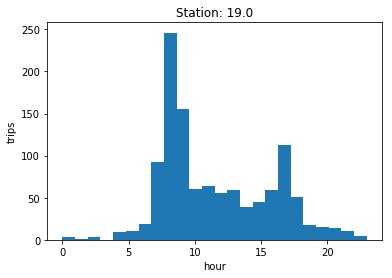

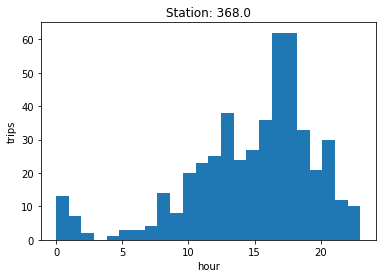

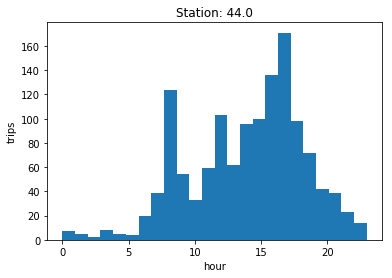

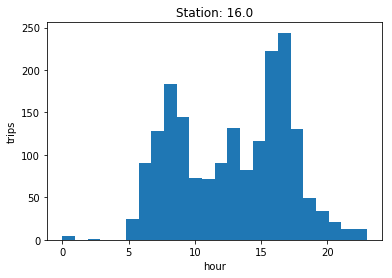

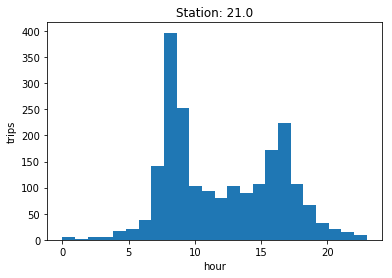

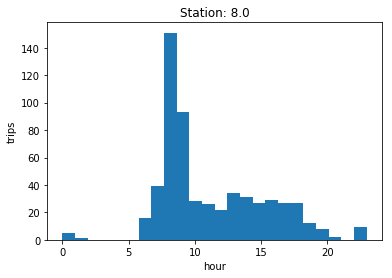

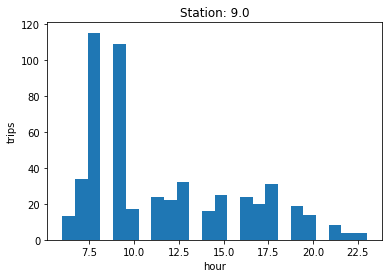

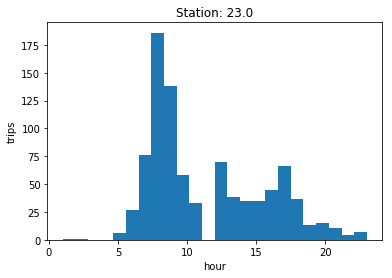

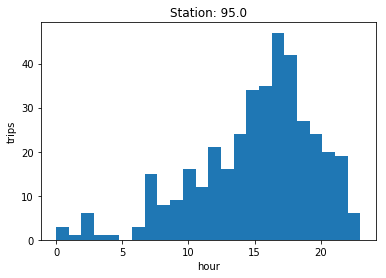

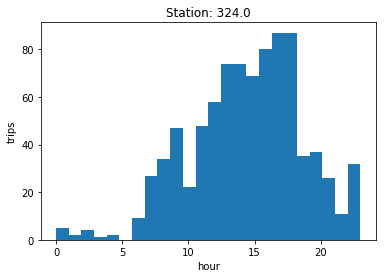

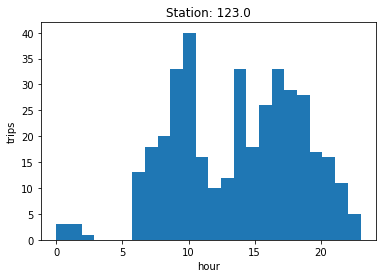

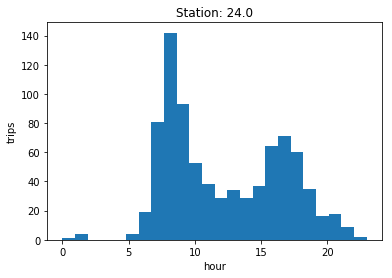

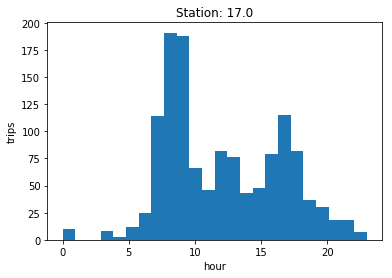

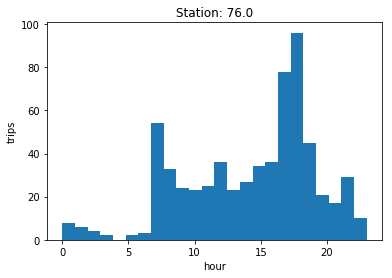

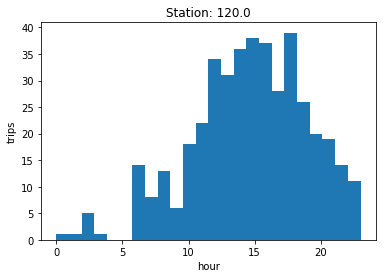

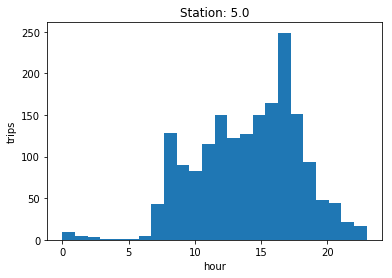

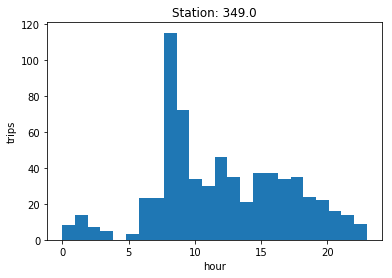

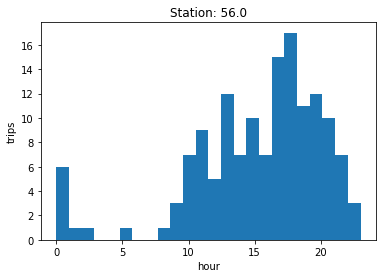

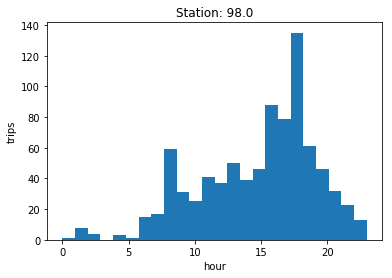

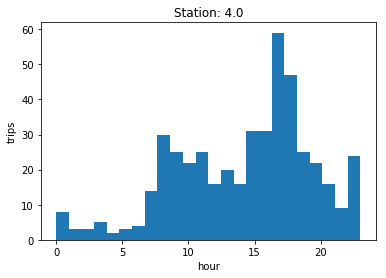

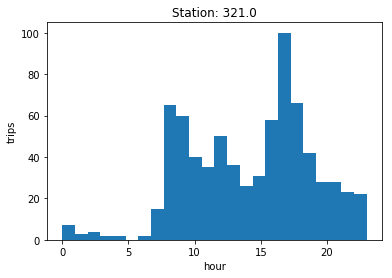

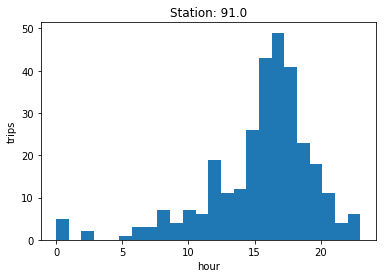

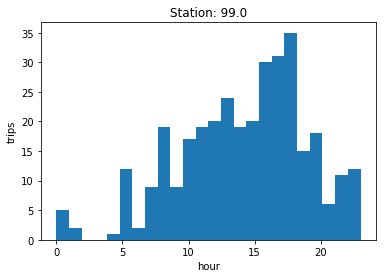

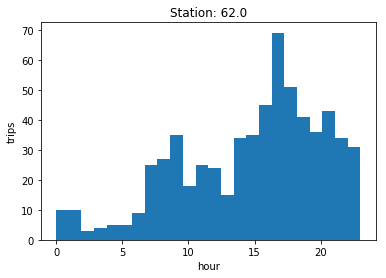

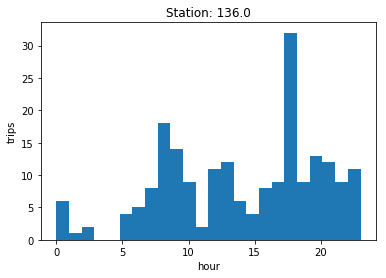

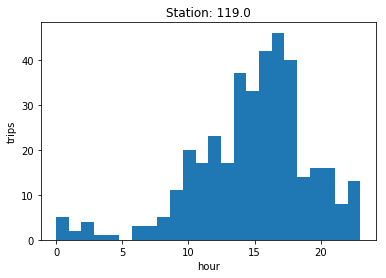

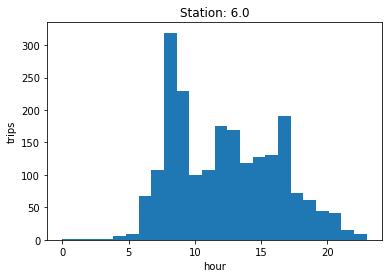

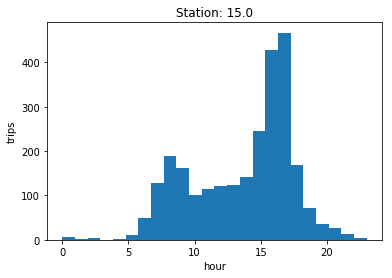

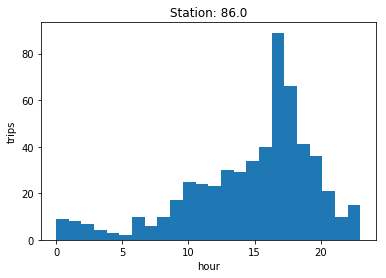

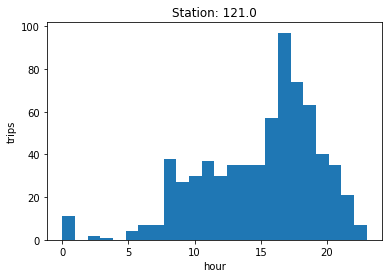

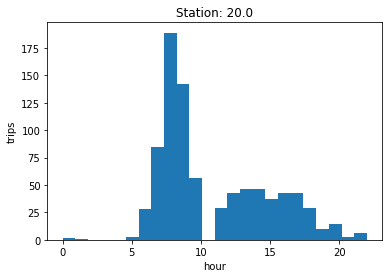

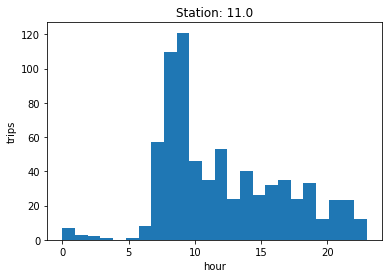

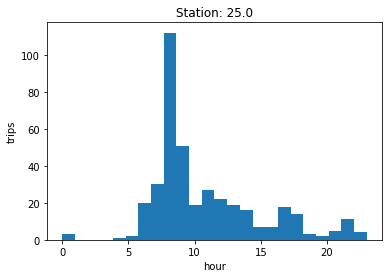

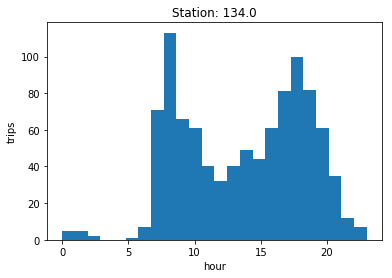

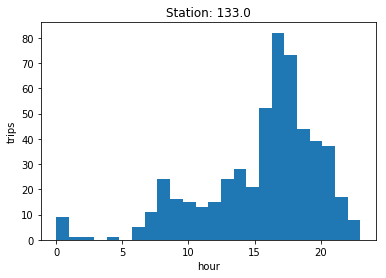

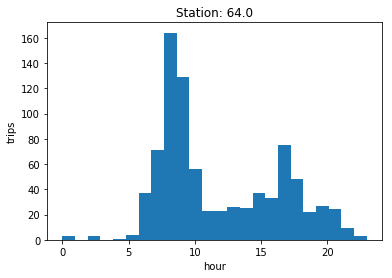

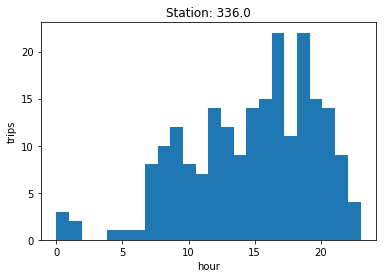

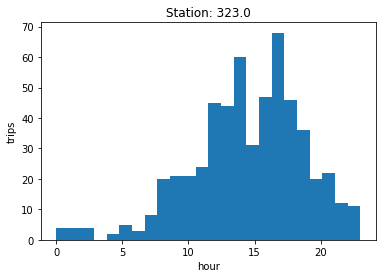

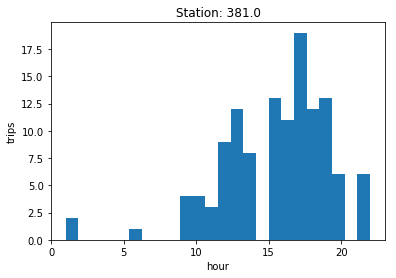

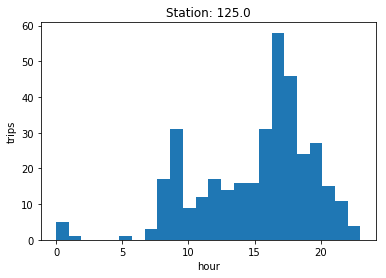

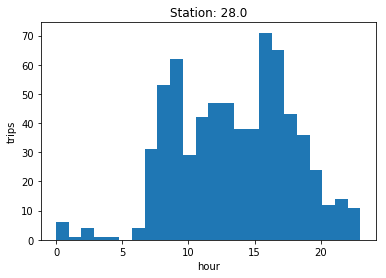

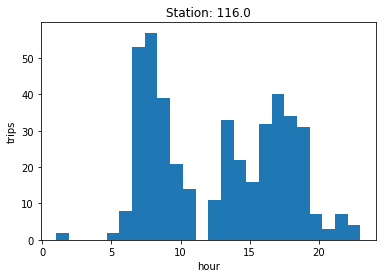

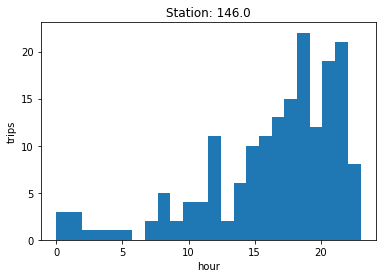

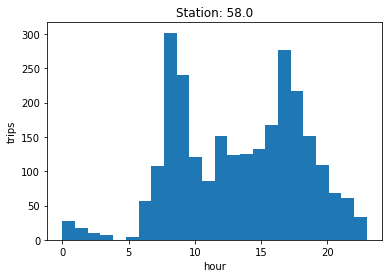

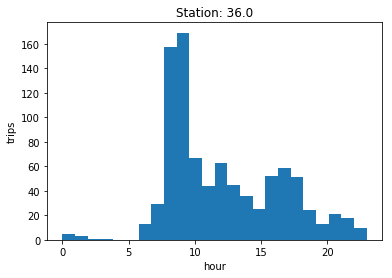

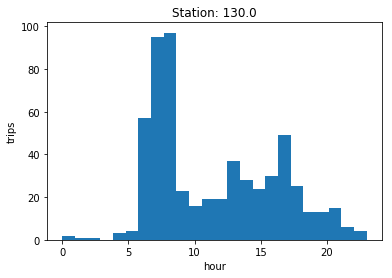

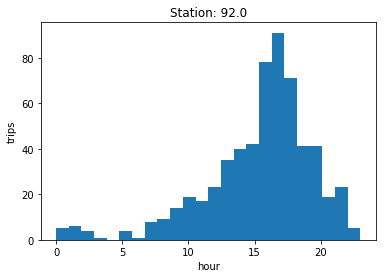

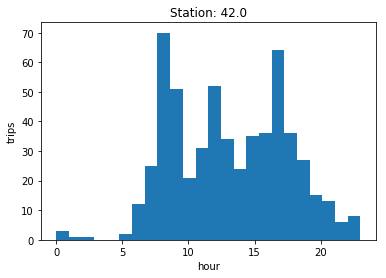

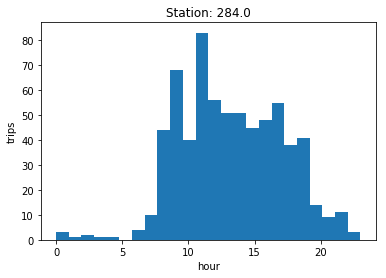

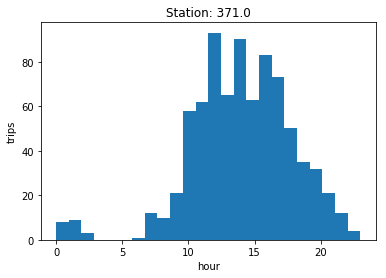

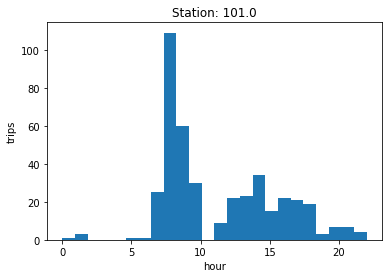

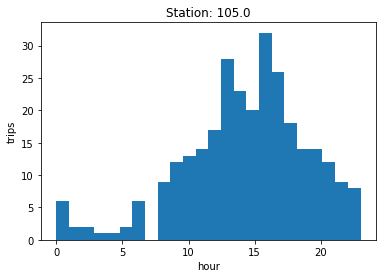

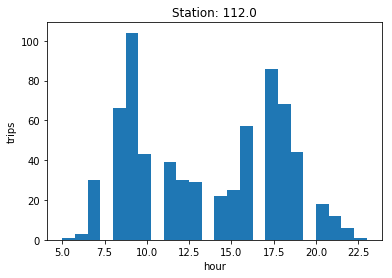

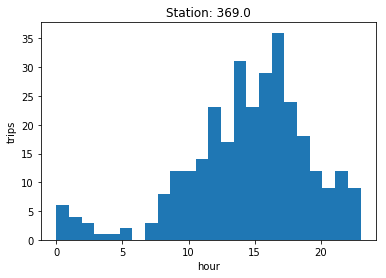

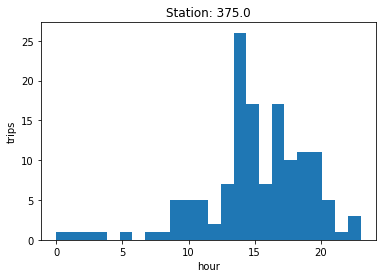

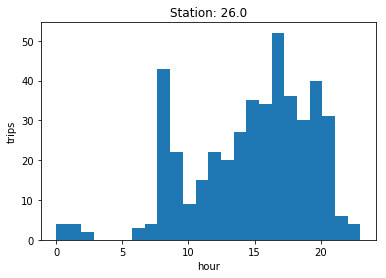

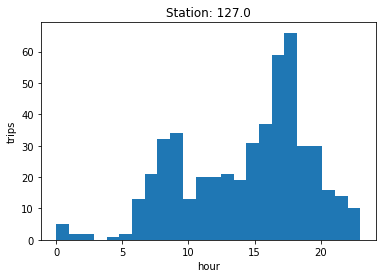

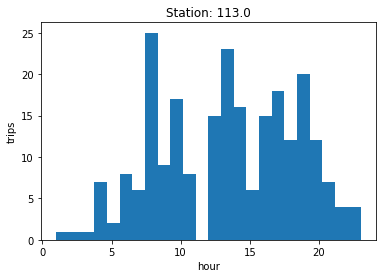

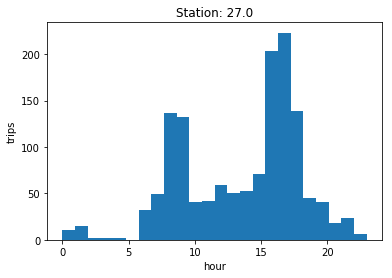

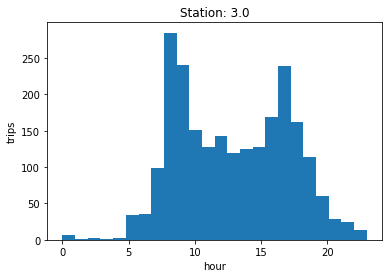

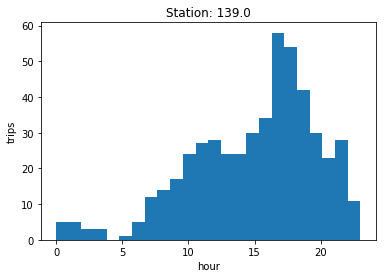

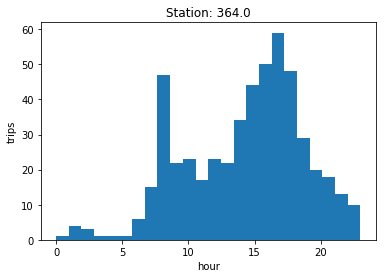

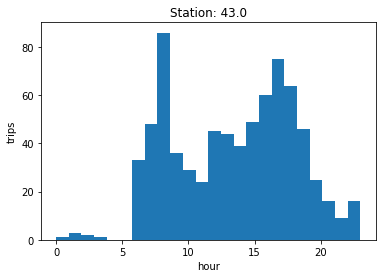

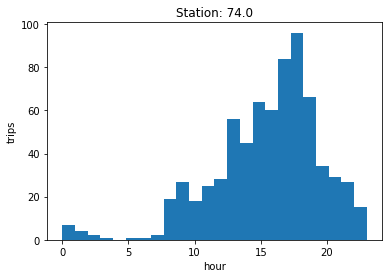

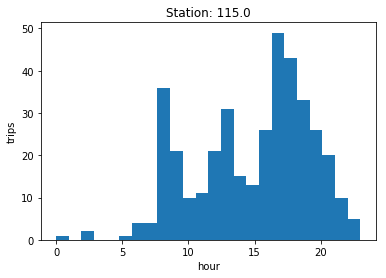

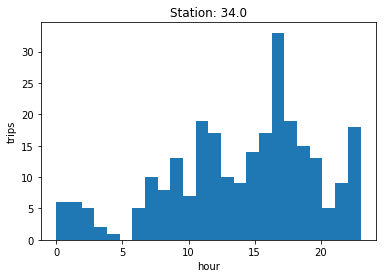

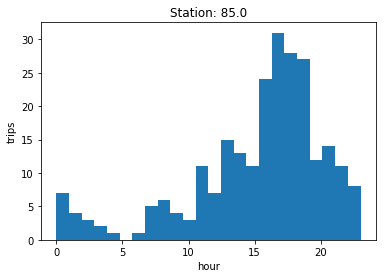

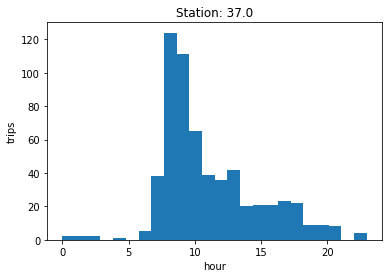

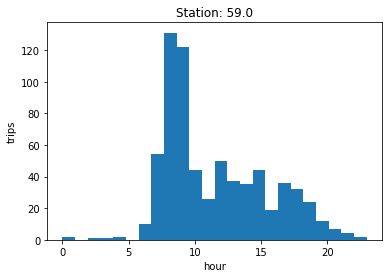

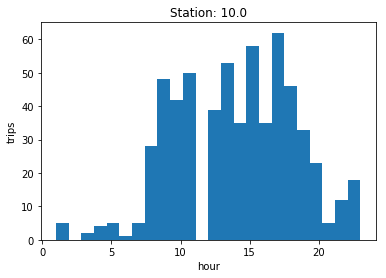

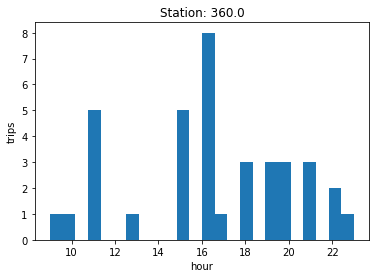

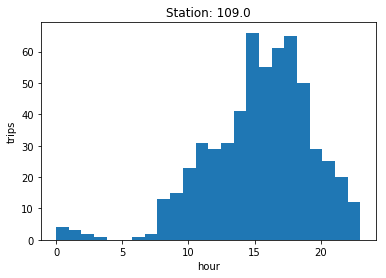

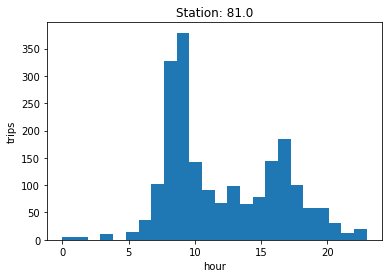

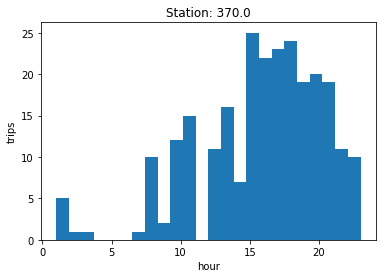

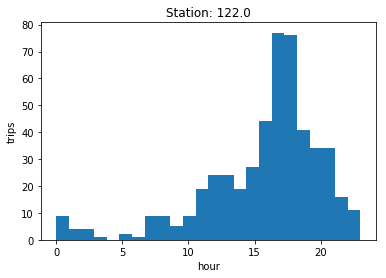

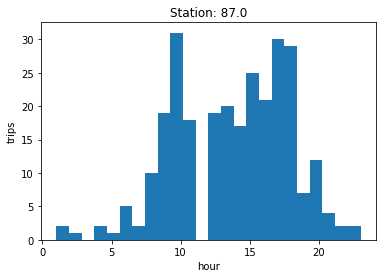

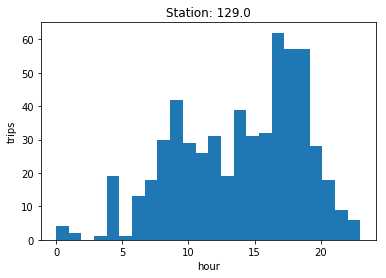

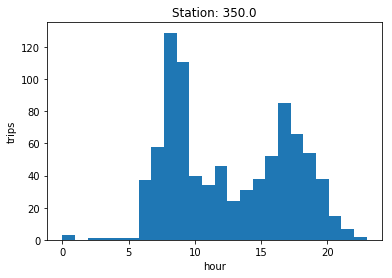

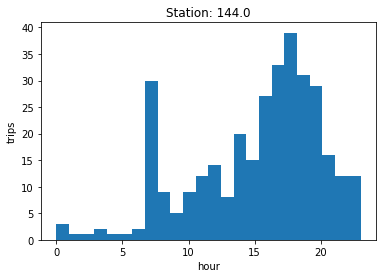

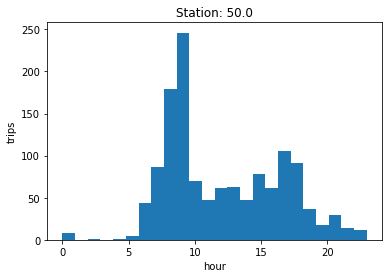

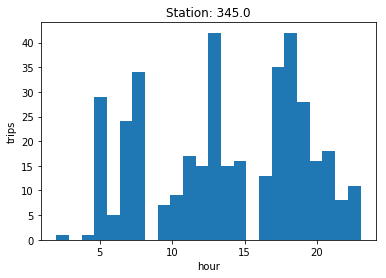

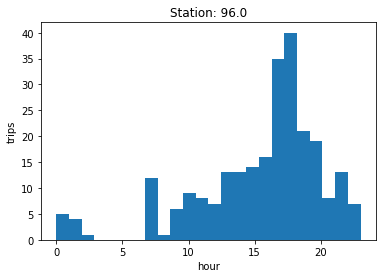

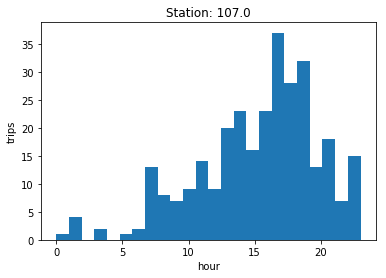

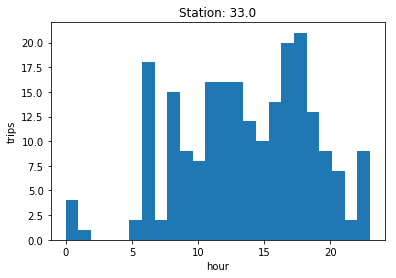

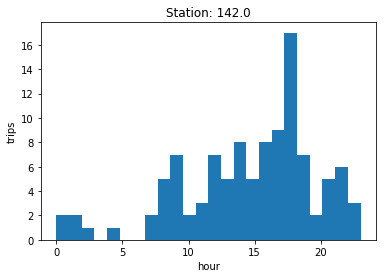

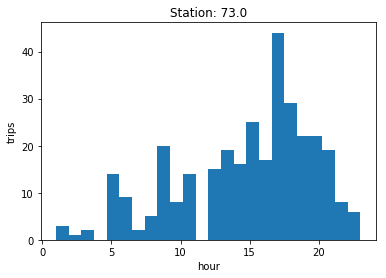

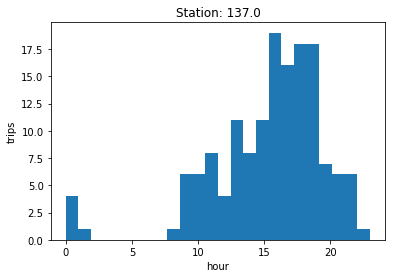

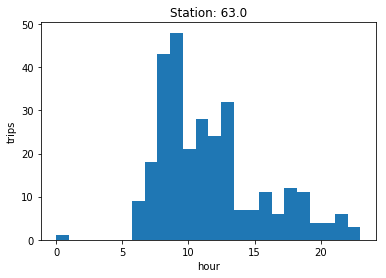

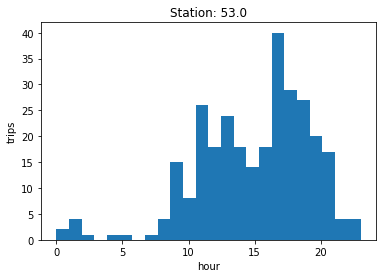

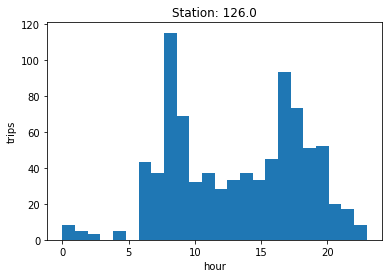

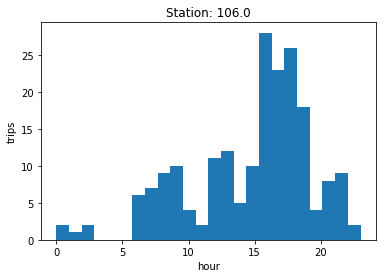

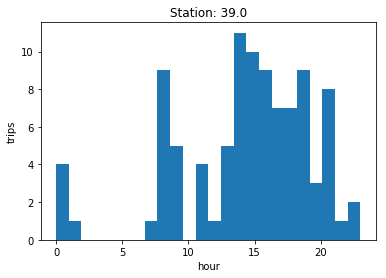

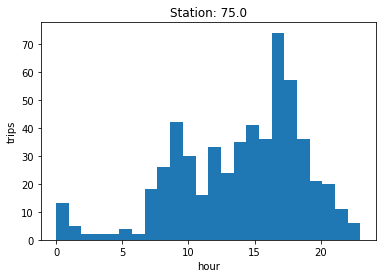

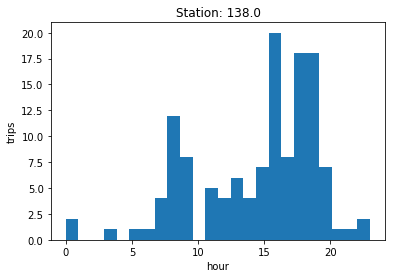

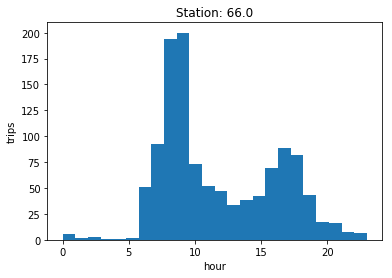

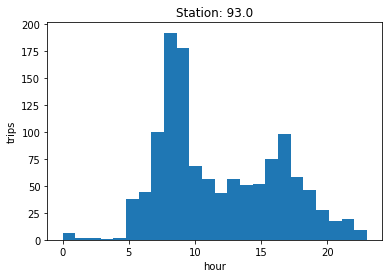

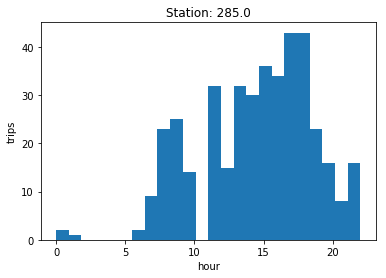

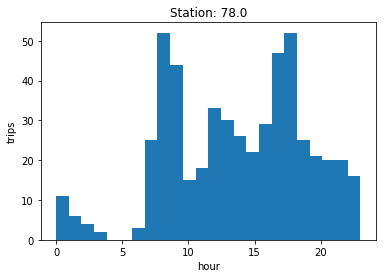

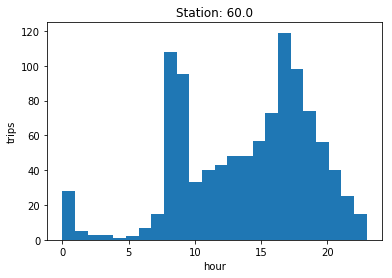

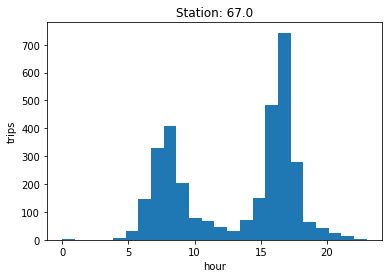

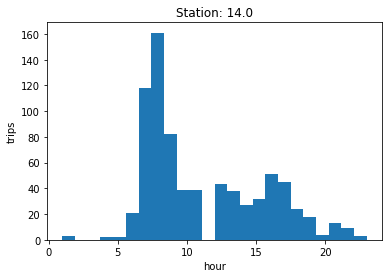

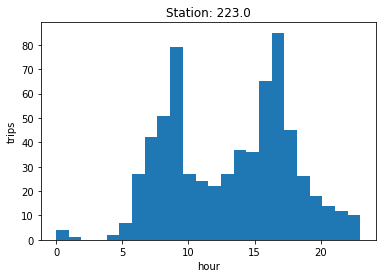

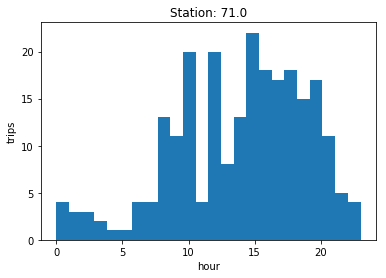

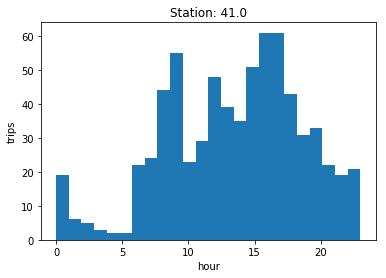

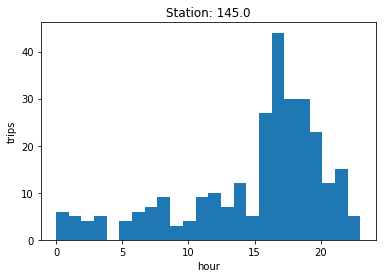

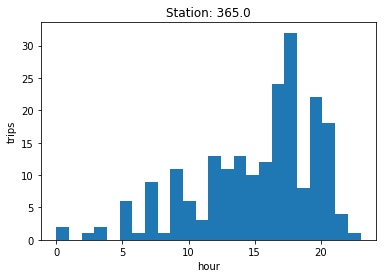

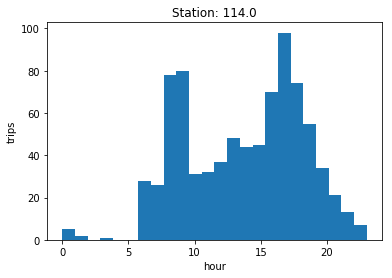

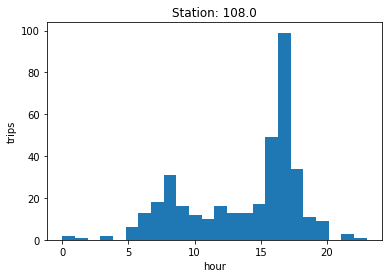

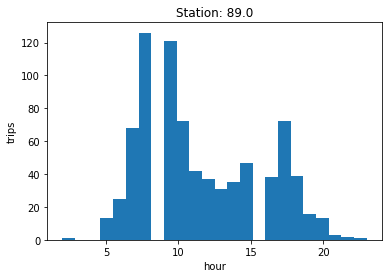

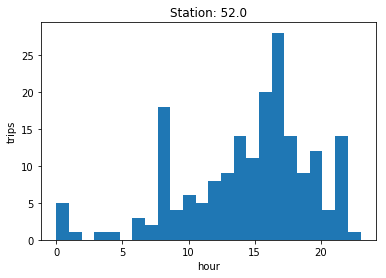

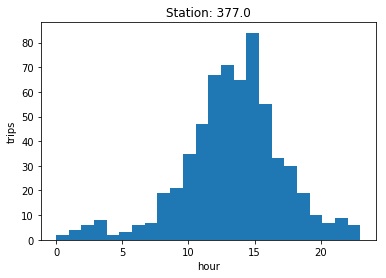

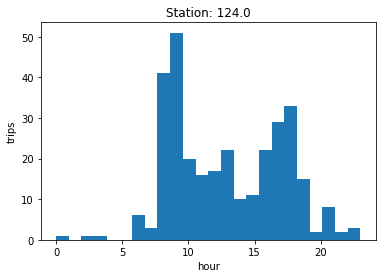

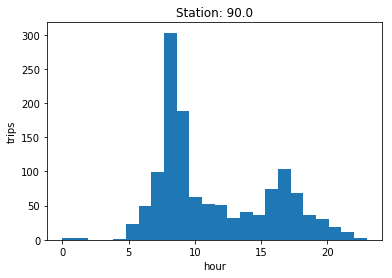

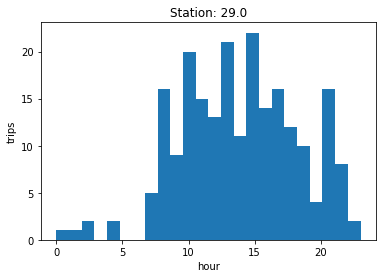

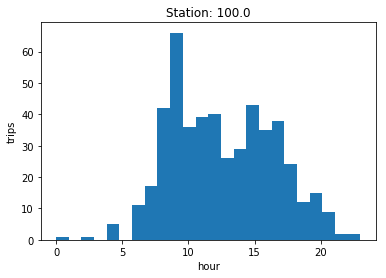

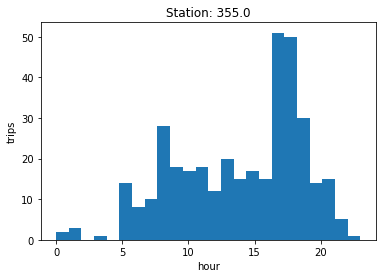

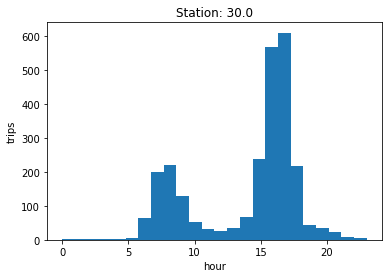

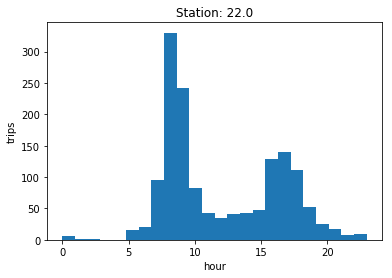

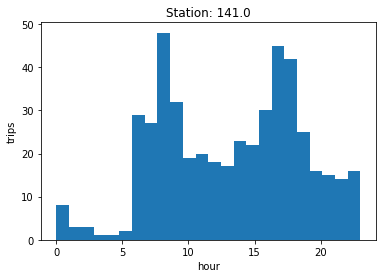

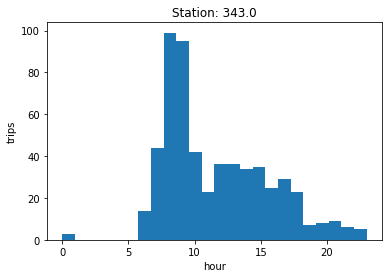

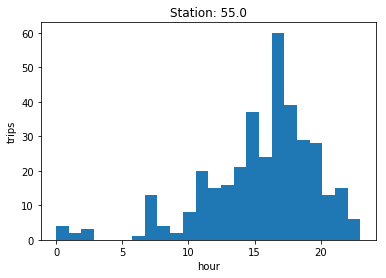

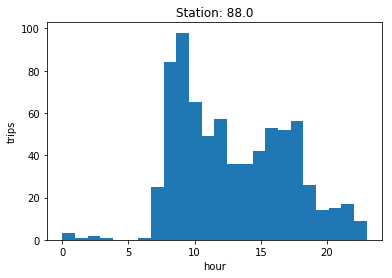

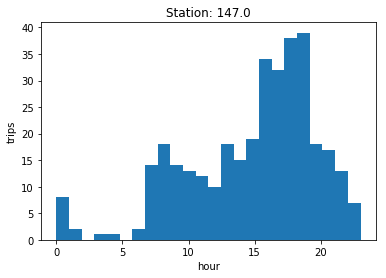

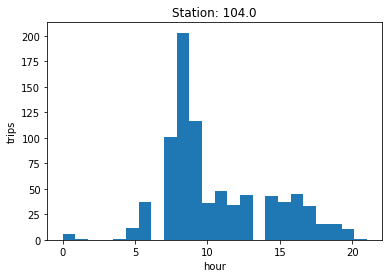

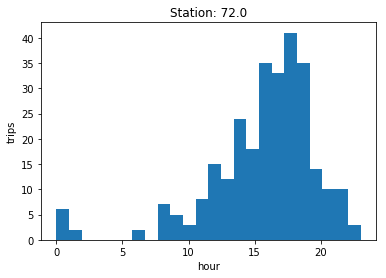

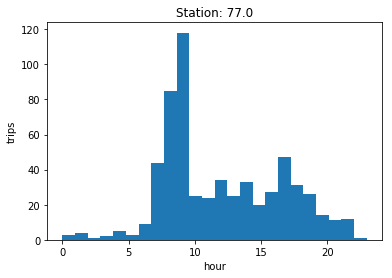

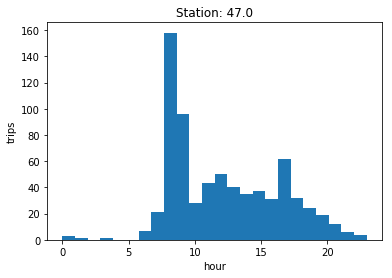

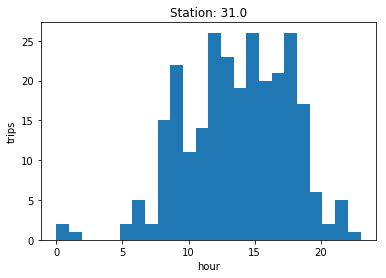

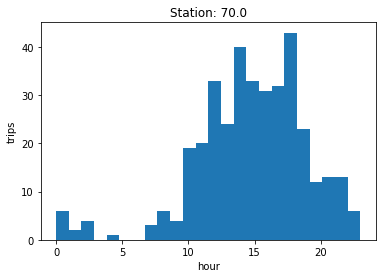

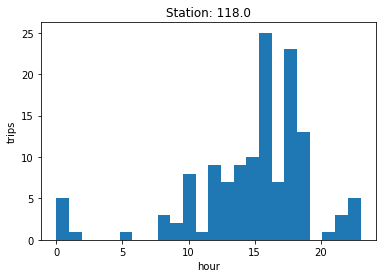

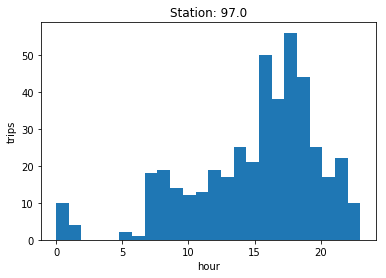

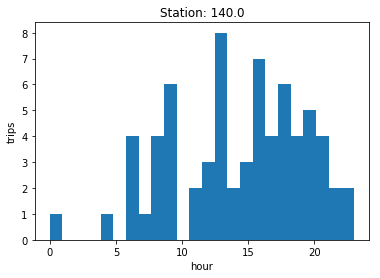

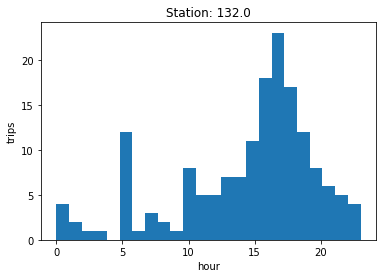

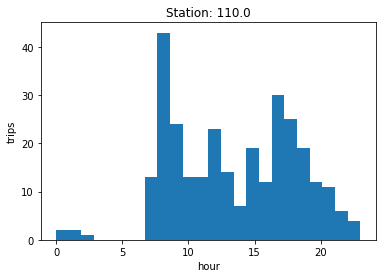

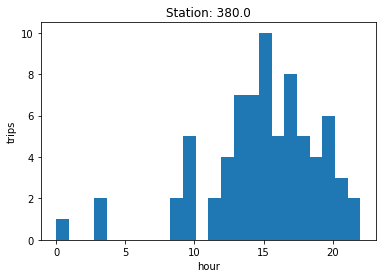

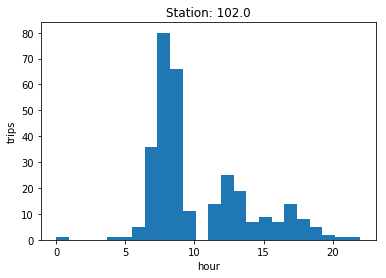

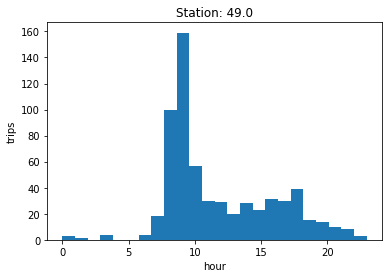

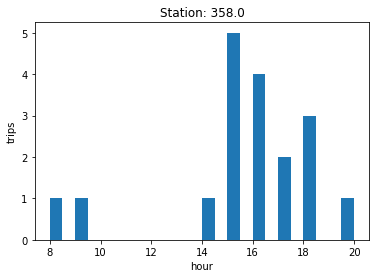

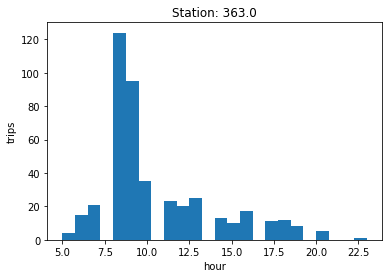

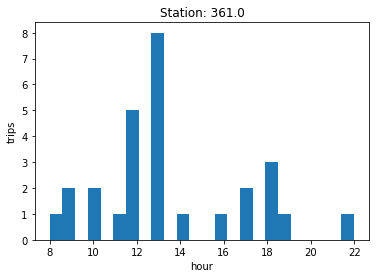

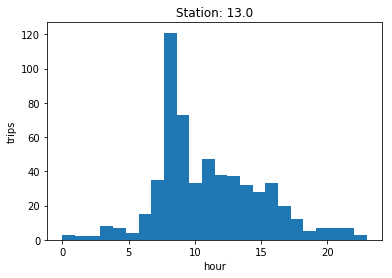

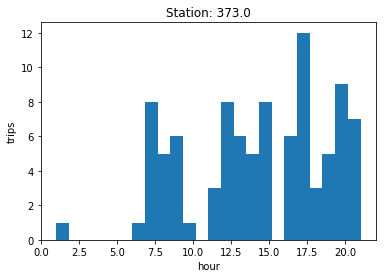

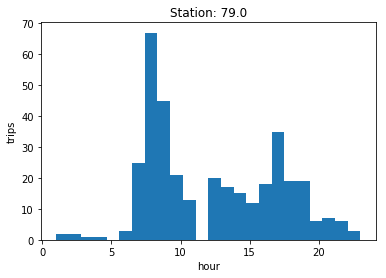

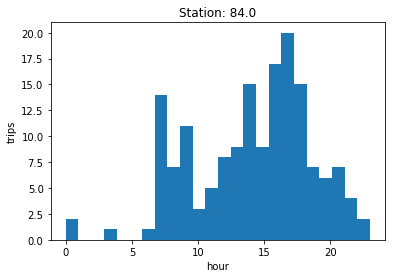

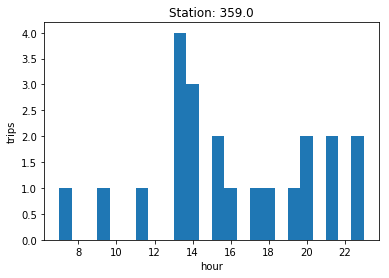

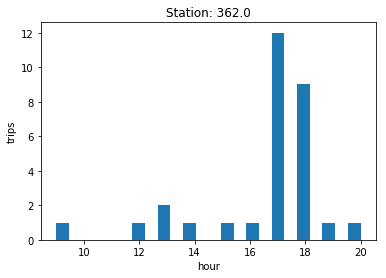

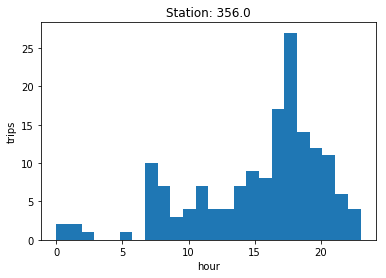

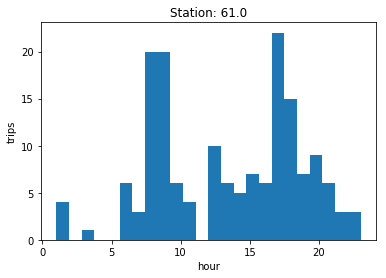

In [45]:
#number of trips for each hour
for station in unique_end_stations:
    plt.xlabel("hour")
    plt.ylabel("trips")
    plt.title("Station: {}".format(station))
    plt.hist(labeled_df[labeled_df.end_station_id == station].hour, bins = 24)
    plt.show()

(array([15957., 14682., 15249., 16131., 13826.,  9418.,  7320.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

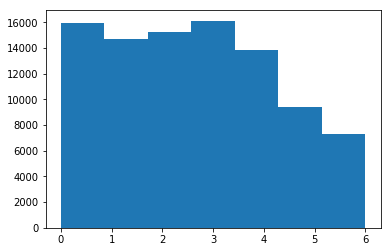

In [46]:
#number of trips per day of week
plt.hist(labeled_df.day_of_week, bins = 7)

(array([ 3127.,  2057., 16553., 18579.,  2584.,  6103.,  4118., 27170.,
        10022.,  2270.]),
 array([50.5, 51.2, 51.9, 52.6, 53.3, 54. , 54.7, 55.4, 56.1, 56.8, 57.5]),
 <a list of 10 Patch objects>)

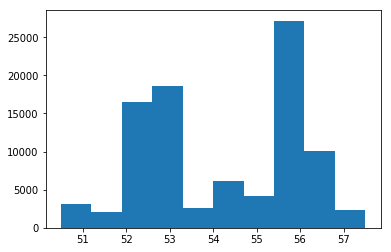

In [137]:
#number of trips for a given temperature
plt.hist(labeled_df.tavg)

(array([4595., 2691., 1140., 1307., 3391., 3168., 2000., 4504., 1232.,
        2520., 2802.,  490.,  261., 1510.,   97., 2016., 1316.,  710.,
        1930.,  486.,  360., 2742., 1731., 1092.,  843., 4398.,  606.,
         603., 1903., 1125., 2390.,    0.,  970., 1021., 2392., 1838.,
         642., 1291., 1245.,  313., 1327.,  678.,  872.,  921., 1647.,
         133., 1492.,  884., 1516.,  498., 1155., 1674.,  205.,  783.,
         545.,  439.,  459.,  345.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  661.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1083.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

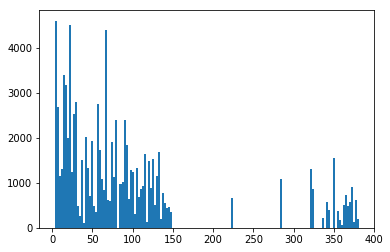

In [49]:
#most popular station
plt.hist(labeled_df.end_station_id, bins = int(150))

### Predicting the duration of a bike trip

In [68]:
X_d = labeled_df[['start_station_id','tavg','prcp','hour', 'user_type']]
y_d = labeled_df['duration_sec']

In [69]:
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d, test_size=0.33, random_state=42)

In [70]:
lr = LinearRegression()
lr.fit(X_d_train, y_d_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [71]:
lr.predict(X_d_test)

array([663.02845825, 656.33696872, 609.89422781, ..., 742.84177957,
       745.00821839, 665.68501317])

In [72]:
lr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [73]:
lr.score(X_d_test, y_d_test)

0.029668766261055524

### First iteration

In [67]:
# X = labeled_df[['duration_sec', 'start_station_id', 'hour', 'day_of_week']]
# y = labeled_df.end_station_id
# # had mean cross val score of 0.136

### Second Iteration

In [68]:
# X = labeled_df[['start_station_id', "day_of_week", "hour","tavg"]]
# y = labeled_df['end_station_id']
# #used own scoring system with knn = 2 and received a score of 0.149

In [87]:
hour_df = labeled_df
X = hour_df[['duration_sec','start_station_id', 'prcp',"day_of_week", "hour","tavg","Female", "age", "user_type"]]
y = hour_df['end_station_id']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#using random forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [89]:
predictions = clf.predict(X_test)

In [90]:
y_test = y_test.reset_index()

In [91]:
score = 0
for pre in range(predictions.shape[0]):
    if np.array(y_test)[pre][1] in knn_dict.get(predictions[pre]):
        score+=1

In [92]:
score/predictions.shape[0]

0.3057310247766177

## Which hour generated the best accuracy score?

In [132]:
def hour_scores(df):
    hour_scores = {}
    for h in range(24):
        hour_df = labeled_df[labeled_df.hour == h]
        X = hour_df[['start_station_id', 'prcp',"day_of_week","tavg"]]
        y = hour_df['end_station_id']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        #using random forest
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        y_test = y_test.reset_index()
        score = 0
        for pre in range(predictions.shape[0]):
            if np.array(y_test)[pre][1] in knn_dict.get(predictions[pre]):
                score+=1
        accuracy = score/predictions.shape[0]
        hour_scores[h] = accuracy
    return hour_scores, hour_df

In [133]:
accuracy_hour, hour_df= hour_scores(labeled_df)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

In [140]:
def plt_scores(scores):
    plt.xlabel("hour")
    plt.ylabel("score")
    plt.title("Accuracy for each hour")
    for k, v in scores.items():
        plt.scatter(k,v, c='g')
    plt.show()

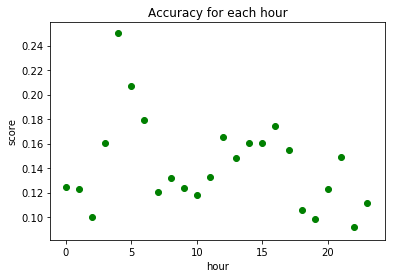

In [141]:
plt_scores(accuracy_hour)

In [134]:
scoring = pd.DataFrame(np.hstack((predictions.reshape(-1,1), np.array(actual)[:,1].reshape(-1,1))))

In [ ]:
#mean score using random forest
# mean_score = cross_val_score(clf,X_test, y_test ).mean()

In [ ]:
mean_score

In [ ]:
master.head(2)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50, 50, 50), random_state=1)
mlpc.fit(X_train, y_train)     

In [ ]:
mlpc.predict(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train[['duration_sec', 'start_station_id', 'tavg']], y_train)

In [ ]:
predictions = lr.predict(X_test[['duration_sec', 'start_station_id', 'tavg']])

In [ ]:
a = np.array(y_test).reshape(-1,1)
type(p)

In [ ]:
p = predictions.reshape(-1,1)
p.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier()
clf.fit(X_train[['duration_sec', 'start_station_id', 'tavg']], y_train)

In [ ]:
rf_predictions = clf.predict(X_test[['duration_sec', 'start_station_id', 'tavg']]).reshape(-1,1)

In [ ]:
str(y[0])

In [ ]:
type(weather.date[0])

In [ ]:

sfi = sf.set_index(sf.date)
weatheri = weather.set_index(weather.date)

In [ ]:
weather.head(5)

In [ ]:
concat_index = pd.concat([sfi, weatheri], axis=1, join_axes=[sfi.index])


In [ ]:
def rf_score(df):
    X = df[['start_station_id', 'tavg', 'hour', 'day_of_week']]
    y = df.end_station_id


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)   
    mean_score = cross_val_score(clf,X_test, y_test ).mean()
    return mean_score

In [ ]:
rf_score(master)